In [2]:
### Project imports ###
import pandas as pd
import numpy as np
import psycopg2 as pg2
import matplotlib.pyplot as plt
import json
import csv
import re
import calendar
from calendar import monthrange

# Project overview
#### Objective: Create a daily labor demand index based on job ads to calculate total available jobs for a given day between 2006-2020      
- In this project, only job ads from Arbetsförmedlingen (JobTechDev) will be used. In a future project, a current labor demand index will be constructed and supplemented with ads through the means of web scraping and API's.
    
- Statistics from the European Commission[<sup>1</sup>](#fn1) shows that the percentage of job seekers using public employment services in EU-countries is among the highest in Sweden, above 70%. Thus, the index may be a good complement to official statistics in measuring labor demand.
    
- Performace of the index will be evaluated through comparison to Swedens official statistics (survey index).

#### Project steps
- Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning).
- Step 2: Inserting data into a postgreSQL database and setting up a query.
- Step 3: Visualization and discussion of results.
- Setp 4: Statistical analysis - Time series decomposition using Loess (In progress).

<span id="fn1"> footnote 1</span>: European Commission (2017) [European Semester Thematic Factsheet](https://wayback.archive-it.org/12090/20201012083437/https://ec.europa.eu/info/sites/info/files/european-semester_thematic-factsheet_public-employment-services_en_0.pdf)

### Step 1: Converting JSON files to CSV and extracting relevant data (+ data cleaning)
#### All job ads data used in this project is from [JobTechDev](https://jobtechdev.se/en/docs/apis/historical/), an initiative by the Swedish public employment service.
- The complete dataset is about 30.8 GB and files are in the JSON-format
- Dataset contains 32 differerent columns/vars, many of which are beyond the scope of the project, as such a selection will be extracted.

- Variables to be extracted for this project are the following:
    - headline: The ad headline
    - number_of_vacancies: The number of advertised jobs for ad
    - publication_date: Date the ad was published on the job ad platform
    - application_deadline: The last date to apply for the job
    - last_publication_date: The last date the ad was public, used as substitutet for application deadline for 2017 where application_deadline is missing

In [2]:
total_valid = 0; total_errors = 0
for file in range(2006,2021):
    filename = f'/Users/Kevin/Desktop/project_dta/json_pb2006_2020/{file}.json'
    with open(filename) as f:
        ads = json.load(f)
        file_ads = []
        error_rows = 0
        
    # For 2017 application_deadline is null, last_publication_date used as a proxy, vars 99.8% equivalent #
    for ad in ads:
        # Removal of special characters using regex, events of \n causes errors in csv file #
        head_line = re.sub('[!,*)@#%(&$_?.^\\\\\n/]', '', str(ad['headline']))
        if file != 2017:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10]]
            except:
                error_rows += 1
                continue
        else:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10]]    
            except:
                error_rows += 1
                continue
                
        # Jobs ads with no vacancies (=0) or missing values (None) in dates or vacancies are removed #
        if all(ad_select[1:]):
            file_ads.append(ad_select)
        else:
            error_rows += 1
            continue

    # We write the extracted data to a csv file for easy insertion into PostgreSQL #             
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/{file}.csv', mode='w', newline="") as file_writer:
        write = csv.writer(file_writer)
        for row in file_ads:
            write.writerow(row)
    print(f'valid ads for {file}: ' + str(len(file_ads)), ' | ', f'erroneous ads for {file}: ' + str(error_rows))
    total_valid += len(file_ads); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), ' | ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2006: 213849  |  erroneous ads for 2006: 31378
valid ads for 2007: 265730  |  erroneous ads for 2007: 18375
valid ads for 2008: 248552  |  erroneous ads for 2008: 16671
valid ads for 2009: 180215  |  erroneous ads for 2009: 15909
valid ads for 2010: 268671  |  erroneous ads for 2010: 20583
valid ads for 2011: 343344  |  erroneous ads for 2011: 21344
valid ads for 2012: 356140  |  erroneous ads for 2012: 23218
valid ads for 2013: 365361  |  erroneous ads for 2013: 24692
valid ads for 2014: 428760  |  erroneous ads for 2014: 23225
valid ads for 2015: 593441  |  erroneous ads for 2015: 20072
valid ads for 2016: 703170  |  erroneous ads for 2016: 14876
valid ads for 2017: 704424  |  erroneous ads for 2017: 10867
valid ads for 2018: 682969  |  erroneous ads for 2018: 0
valid ads for 2019: 640257  |  erroneous ads for 2019: 0
valid ads for 2020: 445120  |  erroneous ads for 2020: 79


total valid ads: 6440003  |  total erroneous ads: 241289


### Step 2: Inserting data into a postgreSQL database and setting up relevant query
 - To more efficiently analyze the dataset it will be imported postgreSQL.

In [3]:
# DB created in pgAdmin4 GUI, login and connect cursor #
conn = pg2.connect(database='job_ads', user='postgres', password='********')
cur = conn.cursor()

In [4]:
# Table creation #
cur.execute("""
CREATE TABLE historic_ads(
    ad_id SERIAL PRIMARY KEY,
    headline VARCHAR,
    number_of_vacancies INTEGER NOT NULL,
    publication_date DATE NOT NULL,
    application_deadline DATE NOT NULL);""")
conn.commit()

In [5]:
# Importing csv files into PostgreSQL #
for file in range(2006, 2021):
    with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/{file}.csv', 'r') as csv_file:
        cur.copy_from(csv_file, 'historic_ads', sep=',', columns=('headline', 'number_of_vacancies', 'publication_date', 'application_deadline'))
    conn.commit()

##### In the cell below we check, for each day between 2006 and 2020, how many ads were active for a given day and then we sum the number of vacancies in these ads.

In [6]:
vacancies_per_day = []
for year in range(2006, 2021):
    for month in range(1,13): 
        # cal.monthrange correctly sets the last day for each month #
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
SELECT SUM(number_of_vacancies) FROM historic_final_f WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline;
""")
            ads_day = [f'{year}-{month}-{day}', cur.fetchone()[0]]
            vacancies_per_day.append(ads_day)
# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/results.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    for row in vacancies_per_day:
        write.writerow(row)

### Step 3: Visualizing and discussion of results
#### The comparison data from Statistics Sweden and can be collected [here](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KVLedigajobbSektor/).
- The comparison data is based on survey results that are published quarterly by Swedens statistical agency, Statistics Sweden (SCB).
- The selected comparison data is between Q1 2006 - Q3 2020 which coincides with our job ads data.

In [4]:
# Importing results and comparison csv files and adding appropriate datetime indexing #
results = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/results.csv', names=['date', 'vacancies'])
results['date'] = pd.to_datetime(results['date'])
comparison = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/lediga_jobb.csv')
comparison['date'] = pd.date_range('2006-01-01','2020-12-01', freq='Q')

In [5]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2006','2022', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2006, 2022)

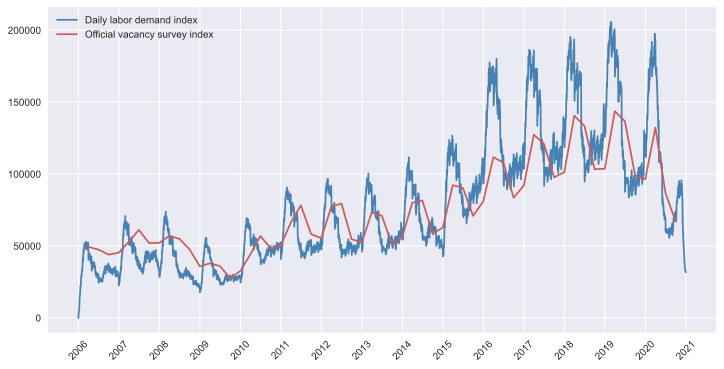

In [6]:
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(results.iloc[:,0], results.iloc[:,1], label='Daily labor demand index', color='steelblue')
plt.plot(comparison.iloc[:,2], comparison.iloc[:,1], label='Official vacancy survey index', color='indianred')

plt.xticks(ticks=date_index, labels=date_range, rotation=45)
plt.legend()

plt.savefig('/Users/Kevin/Desktop/project_dta/figure_results/results.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### Discussion
- In the graph above we observe our labor market index plotted together with Statistics Sweden's quarterly survey. Visually, the two time series show a clear co-movement. Thus, we expect that much of the variation in the official survey will be explained by our index.
- Given that the daily labor market index is behaving as a higher-frequency version of Statistics Sweden's quarterly survey, it could potentially be used as a cheaper and more timely complement.

### Step 4: Statistical analysis - Time series decomposition using Loess (In progress).